## Prioritize the Inspections

We have to inspect a representative set of warning and report those that are highly likely to reply. Each warning belong to a different repository. We have to prioritize the inspections in order to maximize the number of replies.

Some characteristics that we might use to prioritize the inspections are:
1. The number of stars of the repository.
2. The number of forks of the repository.
3. The number of issues of the repository.
4. The number of pull requests of the repository.
5. The number of commits of the repository.
6. The number of contributors of the repository.

We can use the following formula to calculate the priority of a repository:

$$
Priority = \alpha_1 \cdot \frac{stars}{max(stars)} + \alpha_2 \cdot \frac{forks}{max(forks)} + \alpha_3 \cdot \frac{issues}{max(issues)} + \alpha_4 \cdot \frac{pull\_requests}{max(pull\_requests)} + \alpha_5 \cdot \frac{commits}{max(commits)} + \alpha_6 \cdot \frac{contributors}{max(contributors)}
$$

where $\alpha_i$ is the weight of the characteristic $i$.

In [46]:
import project_path
from rdlib import *  # this imports the base libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# DATA
SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-18_17-17-54"
# TARGET NAME
TARGET_FILENAME = "data_sample_fixed_10.csv"
# RAW FILES PATH
RAW_FILES_PATH = "data_sample_fixed_10"
# ANNOTATIONS
ANNOTATIONS_FILENAME = "Annotation_03_data_sample_fixed_10.csv"

GITHUB_TOKEN_PATH = "../secrets/github_access_token.txt"
GITHUB_TOKEN = open(GITHUB_TOKEN_PATH).read().strip()

In [58]:
df = pd.read_csv(os.path.join(SARIF_FOLDER, TARGET_FILENAME))

df_annotations = pd.read_csv(os.path.join(SARIF_FOLDER, ANNOTATIONS_FILENAME))

# Define the function to get the label
def get_label(row):
    if pd.notna(row['Resolution']):
        return row['Resolution']
    else:
        assert row['Annotator_1'] == row['Annotator_2'], "Annotators don't agree"
        return row['Annotator_1']

# Add the 'label' column
df_annotations['label'] = df_annotations.apply(get_label, axis=1)

# Merge on rule_id, message, file, line, col
df = df.merge(df_annotations, on=["rule_id", "message", "file", "line", "col"])

# count different value counts of labels
value_counts = df['label'].value_counts()
print(value_counts)

df.head()



label
TP    55
FP    13
NW     5
Name: count, dtype: int64


/tmp/ipykernel_299410/3056188208.py:17: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = df.merge(df_annotations, on=["rule_id", "message", "file", "line", "col"])


,rule_id,message,file,line,col,index,Annotator_1,Annotator_2,Resolution,Resolution comment,Comment annotator 2,same,label
0,ql-ghost-composition,"Ghost composition at location: (124, 9)",test_mc_gate_13ba80.py,124,9.0,"Ghost composition at location: (124, 9)test_mc...",TP,TP,NaN,NaN,NaN,1,TP
1,ql-ghost-composition,"Ghost composition at location: (249, 1)",error_correction_repetition_code_e94ab1.py,249,NaN,"Ghost composition at location: (249, 1)error_c...",TP,FP,NW,NaN,easy to avoid,0,NW
2,ql-ghost-composition,"Ghost composition at location: (222, 1)",error_correction_repetition_code_e94ab1.py,222,NaN,"Ghost composition at location: (222, 1)error_c...",TP,FP,NW,"because the checker looks for an error, but th...",easy to avoid,0,NW
3,ql-ghost-composition,"Ghost composition at location: (42, 1)",h2evo_6bb46f.py,42,NaN,"Ghost composition at location: (42, 1)h2evo_6b...",TP,TP,NaN,NaN,NaN,1,TP
4,ql-ghost-composition,"Ghost composition at location: (303, 1)",error_correction_repetition_code_e94ab1.py,303,NaN,"Ghost composition at location: (303, 1)error_c...",TP,FP,NW,NaN,easy to avoid,0,NW


In [65]:
def get_url_of_local_file(folder_with_raw_files, file_name):
    """Return the url of the local file.

    Note that the url is stored in the first lines of the local file, thus we
    need to read the file and extract the url.
    """
    with open(os.path.join(folder_with_raw_files, file_name), "r") as f:
        url = f.readline().strip()
    # remove the starting hashtag for comment
    url = url[1:].strip()
    return url

df_with_url = df.copy()
df_with_url["url"] = df_with_url["file"].apply(
    lambda x: get_url_of_local_file(
        os.path.join(SARIF_FOLDER, RAW_FILES_PATH), x))
# extract repo owner
df_with_url["repo_owner"] = df_with_url["url"].apply(lambda x: x.split("/")[3])
# extract repo name
df_with_url["repo_name"] = df_with_url["url"].apply(lambda x: x.split("/")[4])
df_with_url.head()

,rule_id,message,file,line,col,index,Annotator_1,Annotator_2,Resolution,Resolution comment,Comment annotator 2,same,label,url,repo_owner,repo_name
0,ql-ghost-composition,"Ghost composition at location: (124, 9)",test_mc_gate_13ba80.py,124,9.0,"Ghost composition at location: (124, 9)test_mc...",TP,TP,NaN,NaN,NaN,1,TP,https://github.com/qclib/qclib/blob/ddafadf004...,qclib,qclib
1,ql-ghost-composition,"Ghost composition at location: (249, 1)",error_correction_repetition_code_e94ab1.py,249,NaN,"Ghost composition at location: (249, 1)error_c...",TP,FP,NW,NaN,easy to avoid,0,NW,https://github.com/Qiskit/platypus/blob/57c19e...,Qiskit,platypus
2,ql-ghost-composition,"Ghost composition at location: (222, 1)",error_correction_repetition_code_e94ab1.py,222,NaN,"Ghost composition at location: (222, 1)error_c...",TP,FP,NW,"because the checker looks for an error, but th...",easy to avoid,0,NW,https://github.com/Qiskit/platypus/blob/57c19e...,Qiskit,platypus
3,ql-ghost-composition,"Ghost composition at location: (42, 1)",h2evo_6bb46f.py,42,NaN,"Ghost composition at location: (42, 1)h2evo_6b...",TP,TP,NaN,NaN,NaN,1,TP,https://github.com/NEASQC/Variationals_algorit...,NEASQC,Variationals_algorithms
4,ql-ghost-composition,"Ghost composition at location: (303, 1)",error_correction_repetition_code_e94ab1.py,303,NaN,"Ghost composition at location: (303, 1)error_c...",TP,FP,NW,NaN,easy to avoid,0,NW,https://github.com/Qiskit/platypus/blob/57c19e...,Qiskit,platypus


In [44]:
import requests
from datetime import datetime, timezone
from functools import lru_cache

N_GITHUB_API_CALLS = 0

@lru_cache(maxsize=None)
def get_repo_info(owner, repo):
    global N_GITHUB_API_CALLS
    print(f"Number of GitHub API calls: {N_GITHUB_API_CALLS}")
    print(f"Getting info for {owner}/{repo}")
    base_url = f"https://api.github.com/repos/{owner}/{repo}"

    headers = {
        "Authorization": f"Bearer {GITHUB_TOKEN}",
    }

    # Get general repo info
    response = requests.get(base_url, headers=headers)
    data = response.json()
    # if not found return all None
    if data.get("message") == "Not Found":
        return {
            "name": None,
            "stars": None,
            "issues": None,
            "forks": None,
            "contributors": None,
            "commits": None,
            "latest_commit_date": None,
            "days_since_latest_commit": None,
        }

    # Get contributors info
    contributors_response = requests.get(f"{base_url}/contributors", headers=headers)
    contributors_data = contributors_response.json()
    contributors_count = len(contributors_data)

    # Get commits info
    commits_response = requests.get(f"{base_url}/commits", headers=headers)
    commits_data = commits_response.json()
    commits_count = len(commits_data)
    # set default value for latest_commit_date and days_since_latest_commit
    latest_commit_date = None
    days_since_latest_commit = None
    # if there is at least one commit, get the date of the latest commit
    if commits_count > 0:
        try:
            # print(commits_data)
            latest_commit_date = commits_data[0]['commit']['author']['date']

            # Compute the number of days since the latest commit
            latest_commit_date = datetime.strptime(latest_commit_date, "%Y-%m-%dT%H:%M:%SZ")
            # Convert offset-naive datetime to offset-aware datetime
            latest_commit_date = latest_commit_date.replace(tzinfo=timezone.utc)
            now = datetime.now(timezone.utc)
            days_since_latest_commit = (now - latest_commit_date).days
        except:
            print(f"Error while getting latest commit date for {owner}/{repo}")

    N_GITHUB_API_CALLS += 3

    return {
        "name": data["name"],
        "stars": data["stargazers_count"],
        "issues": data["open_issues_count"],
        "forks": data["forks_count"],
        "contributors": contributors_count,
        "commits": commits_count,
        "latest_commit_date": latest_commit_date,
        "days_since_latest_commit": days_since_latest_commit,
    }

# Usage
info = get_repo_info("steurendoit", "QuantumTests")
print(info)

print(N_GITHUB_API_CALLS)

Number of GitHub API calls: 0
Getting info for steurendoit/QuantumTests
{'name': None, 'stars': None, 'issues': None, 'forks': None, 'contributors': None, 'commits': None, 'latest_commit_date': None, 'days_since_latest_commit': None}
0


In [66]:
print(N_GITHUB_API_CALLS)

# Get repo info for each row
df_with_url[['name', 'stars', 'issues', 'forks', 'contributors', 'commits', 'latest_commit_date', 'days_since_latest_commit']] = df_with_url.apply(lambda row: get_repo_info(row['repo_owner'], row['repo_name']), axis=1, result_type='expand')
print(N_GITHUB_API_CALLS)
df_with_url.head()


186
186


,rule_id,message,file,line,col,index,Annotator_1,Annotator_2,Resolution,Resolution comment,...,repo_owner,repo_name,name,stars,issues,forks,contributors,commits,latest_commit_date,days_since_latest_commit
0,ql-ghost-composition,"Ghost composition at location: (124, 9)",test_mc_gate_13ba80.py,124,9.0,"Ghost composition at location: (124, 9)test_mc...",TP,TP,NaN,NaN,...,qclib,qclib,qclib,26.0,9.0,17.0,9.0,30.0,2023-11-10 14:55:49+00:00,80.0
1,ql-ghost-composition,"Ghost composition at location: (249, 1)",error_correction_repetition_code_e94ab1.py,249,NaN,"Ghost composition at location: (249, 1)error_c...",TP,FP,NW,NaN,...,Qiskit,platypus,platypus,93.0,217.0,228.0,30.0,30.0,2023-11-28 19:56:56+00:00,62.0
2,ql-ghost-composition,"Ghost composition at location: (222, 1)",error_correction_repetition_code_e94ab1.py,222,NaN,"Ghost composition at location: (222, 1)error_c...",TP,FP,NW,"because the checker looks for an error, but th...",...,Qiskit,platypus,platypus,93.0,217.0,228.0,30.0,30.0,2023-11-28 19:56:56+00:00,62.0
3,ql-ghost-composition,"Ghost composition at location: (42, 1)",h2evo_6bb46f.py,42,NaN,"Ghost composition at location: (42, 1)h2evo_6b...",TP,TP,NaN,NaN,...,NEASQC,Variationals_algorithms,Variationals_algorithms,0.0,0.0,1.0,3.0,30.0,2022-09-13 09:11:14+00:00,504.0
4,ql-ghost-composition,"Ghost composition at location: (303, 1)",error_correction_repetition_code_e94ab1.py,303,NaN,"Ghost composition at location: (303, 1)error_c...",TP,FP,NW,NaN,...,Qiskit,platypus,platypus,93.0,217.0,228.0,30.0,30.0,2023-11-28 19:56:56+00:00,62.0


In [67]:
print(N_GITHUB_API_CALLS)


186


In [68]:
# store the dataframe in the same folder with the _for_prioritization suffix
df_with_url.to_csv(
    os.path.join(SARIF_FOLDER, TARGET_FILENAME.replace(".csv", "_for_prioritization.csv")), index=False)

## Explorative Data Analysis

/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

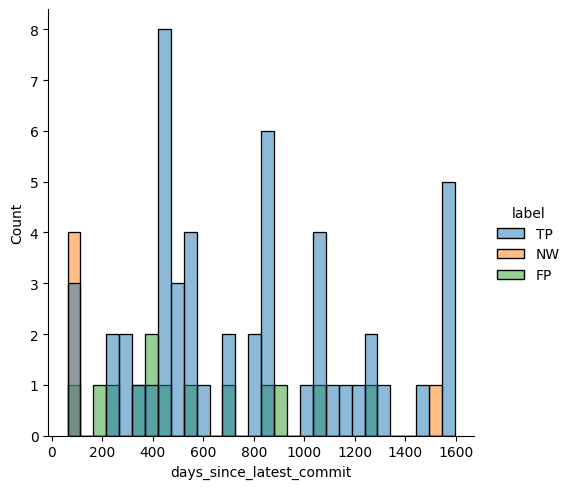

In [70]:
sns.displot(
    df_with_url,
    x="days_since_latest_commit",
    hue="label",
    bins=30)

/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

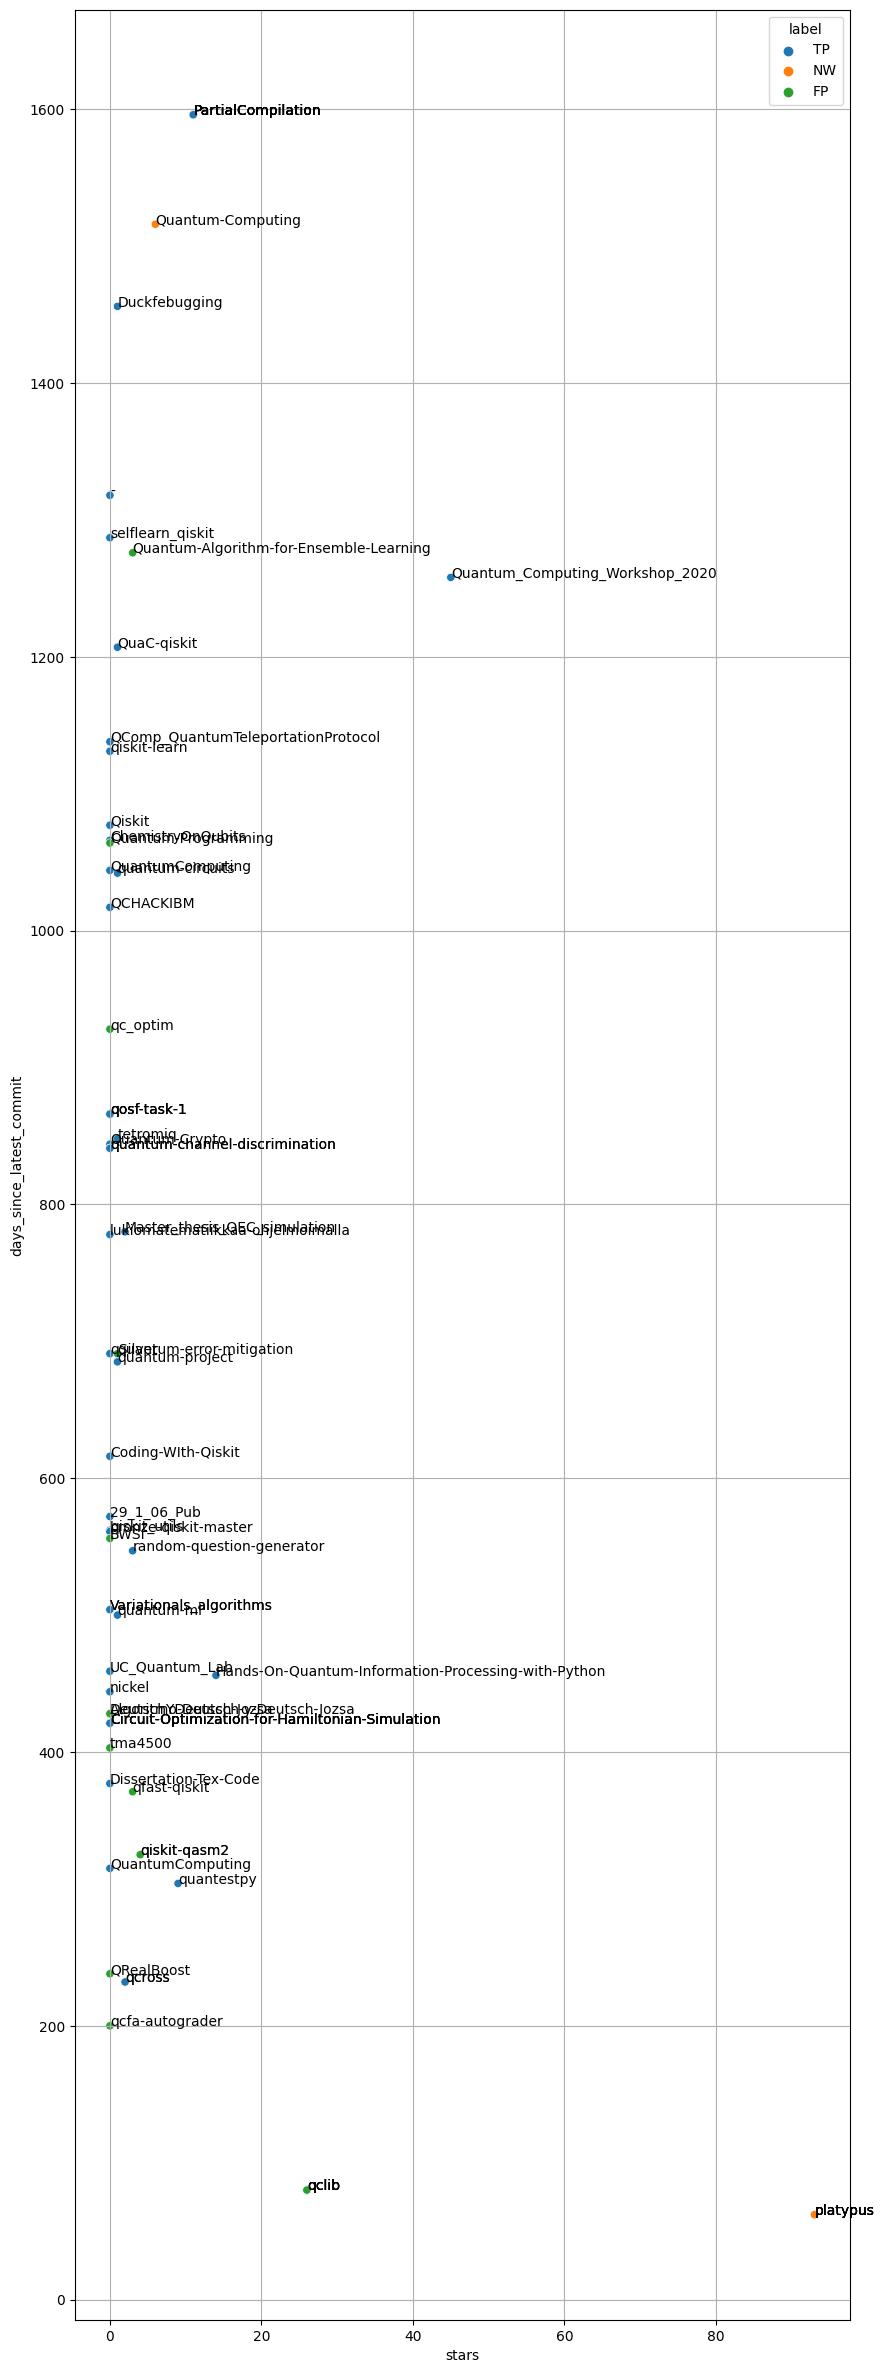

In [77]:
plt.figure(figsize=(10, 30))  # Set the figure size

sns.scatterplot(
    data=df_with_url,
    y="days_since_latest_commit",
    x="stars",
    hue="label",
)

# Add labels next to the dots
for i in range(len(df_with_url)):
    plt.text(
        df_with_url["stars"][i],
        df_with_url["days_since_latest_commit"][i],
        df_with_url["name"][i])

plt.grid(True)  # Add grid lines

plt.show()  # Show the plot


In [91]:
TOP_K = 15

df_to_prioritize = df_with_url.copy()

columns_to_rank = ['stars', 'issues', 'contributors', 'days_since_latest_commit']

for column in columns_to_rank:
    if column == 'days_since_latest_commit':
        df_to_prioritize[f'{column}_percentile'] = df_to_prioritize[column].rank(
            pct=True, ascending=False)
    else:
        df_to_prioritize[f'{column}_percentile'] = df_to_prioritize[column].rank(
            pct=True)

# scoring
df_to_prioritize['score'] = df_to_prioritize['stars_percentile'] + \
    df_to_prioritize['issues_percentile'] + \
    df_to_prioritize['contributors_percentile'] + \
    df_to_prioritize['days_since_latest_commit_percentile']

# sort by score
df_to_prioritize = df_to_prioritize.sort_values(by='score', ascending=False)

# keep rule_id, message, file, line, col, label, score
df_to_prioritize = df_to_prioritize[
    ['rule_id', 'message', 'file', 'line', 'col', 'label', 'score']]

# keep only label == 'TP'
df_to_prioritize = df_to_prioritize[df_to_prioritize['label'] == 'TP']

# create the code from file and line:
# e.g. test_mc_gate_13ba80.py	107 becomes, 13ba80_107
df_to_prioritize.insert(0, 'code', df_to_prioritize.apply(
    lambda row: f"{row['file'].split('_')[-1].split('.')[0]}_{row['line']}", axis=1))

df_to_prioritize.head(TOP_K)


,code,rule_id,message,file,line,col,label,score
7,13ba80_107,ql-ghost-composition,"Ghost composition at location: (107, 9)",test_mc_gate_13ba80.py,107,9.0,TP,3.642857
0,13ba80_124,ql-ghost-composition,"Ghost composition at location: (124, 9)",test_mc_gate_13ba80.py,124,9.0,TP,3.642857
8,13ba80_90,ql-ghost-composition,"Ghost composition at location: (90, 9)",test_mc_gate_13ba80.py,90,9.0,TP,3.642857
66,940648_43,ql-unmeasurable-qubits,Circuit 'qc' has more qubits (3) than classica...,test_u_gate_940648.py,43,14.0,TP,3.307143
32,9498d5_10,ql-measure-all-abuse,measure_all() on the circuit 'circuit' (at loc...,qrng_9498d5.py,10,5.0,TP,2.957143
63,69a67f_271,ql-oversized-circuit,Circuit 'qc3' never manipulates some of its 1q...,day_203_20universality_69a67f.py,271,7.0,TP,2.721429
24,e3f4e0_74,ql-double-measurement,Two consecutive measurements on qubit '0' at l...,quantum_e3f4e0.py,74,5.0,TP,2.635714
41,28325b_157,ql-operation-after-measurement,Operation 'cx' on qubit 1 after measurement at...,ch_3_28325b.py,157,NaN,TP,2.614286
44,9232ea_55,ql-op-after-optimization,Operation measure applied to transpiled circui...,groverfuncs_9232ea.py,55,5.0,TP,2.442857
16,352e8e_34,ql-conditional-without-measurement,"Conditional gate 'h' on qubit '2' (l: 34, c: 1...",test_sdk_352e8e.py,34,NaN,TP,2.321429


In [82]:
from IPython.display import display

TOP_K = 15
COLUMN_TO_SHOW = ["name", "file", "line", "col", "stars", "issues", "contributors", "days_since_latest_commit"]


ATTRIBUTES_TO_PRIORITIZE = [
    "stars",
    "issues",
    "contributors",
    "days_since_latest_commit",
]

# keep only TP
df_to_prioritize = df_with_url[df_with_url["label"] == "TP"]
df


for attr in ATTRIBUTES_TO_PRIORITIZE:
    order_ascending = False
    if attr == "days_since_latest_commit":
        order_ascending = True
    df_to_prioritize = df_to_prioritize.sort_values(
        by=[attr], ascending=order_ascending)
    print(f"Top {TOP_K} {attr}:")
    display(df_to_prioritize[COLUMN_TO_SHOW].head(TOP_K))

Top 15 stars:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
63,Quantum_Computing_Workshop_2020,day_203_20universality_69a67f.py,271,7.0,45.0,1.0,4.0,1258.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
41,Hands-On-Quantum-Information-Processing-with-P...,ch_3_28325b.py,157,NaN,14.0,0.0,3.0,456.0
21,PartialCompilation,test_qasm_simulator_edd048.py,61,9.0,11.0,0.0,3.0,1596.0
18,PartialCompilation,test_circuit_qasm_ae5268.py,47,9.0,11.0,0.0,3.0,1596.0
12,PartialCompilation,test_decompose_78559e.py,75,9.0,11.0,0.0,3.0,1596.0
17,PartialCompilation,test_circuit_load_from_qasm_bf30ab.py,114,9.0,11.0,0.0,3.0,1596.0
11,PartialCompilation,test_decompose_78559e.py,83,9.0,11.0,0.0,3.0,1596.0


Top 15 issues:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
24,tetromiq,quantum_e3f4e0.py,74,5.0,1.0,15.0,3.0,848.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
35,Duckfebugging,one_qubit_fb6117.py,40,NaN,1.0,6.0,2.0,1456.0
60,29_1_06_Pub,4atoms_of_computation_332679.py,126,6.0,0.0,6.0,2.0,572.0
32,random-question-generator,qrng_9498d5.py,10,5.0,3.0,3.0,4.0,547.0
44,Dissertation-Tex-Code,groverfuncs_9232ea.py,55,5.0,0.0,2.0,2.0,377.0
47,Circuit-Optimization-for-Hamiltonian-Simulation,real_system_c4c34f.py,59,5.0,0.0,1.0,1.0,421.0


Top 15 contributors:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
16,quantum-project,test_sdk_352e8e.py,34,NaN,1.0,0.0,5.0,685.0
63,Quantum_Computing_Workshop_2020,day_203_20universality_69a67f.py,271,7.0,45.0,1.0,4.0,1258.0
32,random-question-generator,qrng_9498d5.py,10,5.0,3.0,3.0,4.0,547.0
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
24,tetromiq,quantum_e3f4e0.py,74,5.0,1.0,15.0,3.0,848.0
12,PartialCompilation,test_decompose_78559e.py,75,9.0,11.0,0.0,3.0,1596.0
41,Hands-On-Quantum-Information-Processing-with-P...,ch_3_28325b.py,157,NaN,14.0,0.0,3.0,456.0


Top 15 days_since_latest_commit:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
50,qcross,source_948f90de9947418289b220bd2e61caa3_caae3b.py,58,NaN,2.0,0.0,1.0,232.0
49,qcross,source_59a0eb956a0d4e6b8720f272136f2799_9b8ba7.py,34,NaN,2.0,0.0,1.0,232.0
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
40,QuantumComputing,quantum_key_distribution_e8abe3.py,73,NaN,0.0,0.0,1.0,315.0
13,qiskit-qasm2,test_structure_aaba85.py,245,9.0,4.0,0.0,1.0,325.0
44,Dissertation-Tex-Code,groverfuncs_9232ea.py,55,5.0,0.0,2.0,2.0,377.0
48,Circuit-Optimization-for-Hamiltonian-Simulation,real_system_c4c34f.py,64,5.0,0.0,1.0,1.0,421.0
